# Naive Bayes On Amazon Fine Food Reviews 

## [ CONTENTS ] 

1. About the dataset<br>
2. Objective<br>
3. Loading the data<br>
4. Data Preprocessing <br>
5. Naive Bayes on k-Fold cross validation<br>
6. Bag of Words (BoW)<br>
    6.1 Bi-Grams & N-Grams<br>
7. TF-IDF<br>
8. Conclusion<br>

## 1. About the dataset
1. Title: Amazon Fine Food Reviews. Link:https://www.kaggle.com/snap/amazon-fine-food-reviews
2. Relevant Information: This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.
3. Data includes:
    * Number of reviews: 568,454<br>
    * Number of users: 256,059<br>
    * Number of products: 74,258<br>
    * Timespan: Oct 1999 - Oct 2012<br>
    * Number of Attributes/Columns in data: 10 
4. Attribute Information: 
    * Id
    * ProductId - unique identifier for the product
    * UserId - unqiue identifier for the user
    * ProfileName
    * HelpfulnessNumerator - number of users who found the review helpful
    * HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    * Score - rating between 1 and 5
    * Time - timestamp for the review
    * Summary - brief summary of the review
    * Text - text of the review

## 2. Objective:
For a given Amazon review, classify it as "Possitive"(Rating of 4 or 5) or "Negative"(Rating of 1 or 2).<br>
<br>
Here I'm using naive bayes algorithm to classify reviews as 'positive' or 'negative'. To convert a review text to numerical features I'm using bag of words(BoW) and TF-IDF. 

In [1]:
# importing required libraries
import numpy as np
import pandas as pd 
import matplotlib 
import sqlite3
import string
import nltk
import time
from matplotlib import pyplot as plt 
import seaborn as sns 
from sklearn.naive_bayes import MultinomialNB
from matplotlib.colors import ListedColormap
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# importing required libraries
from sklearn.model_selection import KFold
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as prf1

## 3. Loading the data

In [3]:
# Loading the previously cleaned data
connect = sqlite3.connect('final_data.sqlite')

#Ignoring the rows which have rating 3
data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", connect)

Loading the pre-processed data using sqlite. This dataset has no entry with score 3 which is previously removed. And the scores which are greater than 3 are denoted as 'positive' and which are less than 3 are denoted as 'negative' scores.

In [4]:
data.shape

(364171, 12)

In [5]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


## 4. Data Preprocessing

Loaded data is imbalanced and here, I'm using downsampling method to balance this dataset.

In [6]:
data.Score.value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [7]:
# some data preprocessing
from sklearn.utils import resample

df_majority = data[data.Score=='positive']
df_minority = data[data.Score=='negative']
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=57110,     # to match minority class
                                 random_state=1) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [8]:
df_downsampled.shape

(114220, 12)

In [9]:
# sorting the data based on time-stamp
sorted_data = df_downsampled.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
# converting 'positive' score to 1 and 'negative' score to 0
def partition(x):
    if x == 'positive':
        return 1
    return 0

actualScore = sorted_data['Score']
positiveNegative = actualScore.map(partition) 
sorted_data['Score'] = positiveNegative

## 5. Naive Bayes & K-Fold Cross Validation

In [11]:
# applying Multinomial Naive Bayes and cross-validating
def cross_val(data, score):

    # split the data set into train and test
    global train_x
    global train_y
    global test_x
    global test_y
    
    train_x, test_x, train_y, test_y = train_test_split(data, score, test_size=0.3, random_state=0)

    # spliting the train data set into cross validation train and cross validation test
    kfold = KFold(3, shuffle=False, random_state=1)

    alpha_val = [0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100,500,1000,5000,10000]
    cv_err = []
    test_err = []
    for train, cv in kfold.split(train_x):
        for i in alpha_val:
            nb = MultinomialNB(i, fit_prior=True, class_prior=None)

            # fitting the model on cross-validation train
            nb.fit(train_x[train], train_y[train])

            # predict the response on the cross-validation train
            cv_err.append(1 - (nb.score(train_x[cv], train_y[cv])))
            test_err.append(1 - (nb.score(test_x, test_y)))

    return cv_err, test_err

In [12]:
# comparing model errors on cv and test data
def error_comparision(cv_err, test_err):
    sns.set()
    alpha_val = [0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100,500,1000,5000,10000]
    # plotting error curves
    for i in range(3):
        plt.figure(1)
        plt.figure(figsize=(9,12))
        plt.subplot(3,1,i+1)
        plt.plot(alpha_val, cv_err[i, :],label = 'cv_error')
        plt.plot(alpha_val, test_err[i, :],label = 'test_error')
        plt.xscale('log')
        plt.xlabel('Alpha-Values')
        plt.ylabel('Error Values')
        plt.legend()
        plt.title('CV & TEST-ERR for Fold '+str(i+1))

In [13]:
# plotting ROC curve along with confusion matrix
def final_test_acc(best_a, name):
    nb = MultinomialNB(best_a, fit_prior=True, class_prior=None)
    nb.fit(train_x,train_y)
    pred = nb.predict(test_x)
    acc = accuracy_score(test_y, pred, normalize=True) * float(100)
    print("\nTest accuracy for alpha = '{0}' is '{1}'".format(best_a, acc))
    y_pred_proba = nb.predict_proba(test_x)[::,1]
    fpr, tpr, thresholds = roc_curve(test_y, y_pred_proba)
    
    sns.set()
    plt.figure(figsize=(8,5))
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr, tpr, label='NB')
    plt.xlabel('False-Positive Rate')
    plt.ylabel('True-Positive Rate')
    plt.title('NB ROC curve for '+name+' with alpha '+str(best_a))
    plt.show()
    print('Area under the ROC curve is ', roc_auc_score(test_y, y_pred_proba))
    conf_matx = confusion_matrix(test_y,pred)
    print('\nConfusion Matrix :\n', conf_matx)
    norm_conf_matx = conf_matx / conf_matx.astype(np.float).sum(axis=1).reshape(2,1)
    print('\nNormalized Confusion Matrix :\n', norm_conf_matx)
    plt.figure(figsize=(8,5))
    plot = sns.heatmap(norm_conf_matx, annot=True, xticklabels=['Negative Review', 'Positive Review'], yticklabels=['Negative Review','Positive Review'])
    plot.set_yticklabels(plot.get_yticklabels(), rotation = 0, fontsize = 10)
    plt.title('Confusion Matrix Heatmap', fontsize=18)
    
    precision, recall, fscore, support = prf1(test_y, pred)
    print('\nPrecision  : {0:.2f}%, {1:.2f}%'.format(precision[0]*100, precision[1]*100))
    print('Recall     : {0:.2f}%, {1:.2f}%'.format(recall[0]*100, recall[1]*100))
    print('F1-score   : {}'.format(fscore))

In [14]:
# finding top features for each class
def top_features(vectorizer, top_n, alpha):
    nb = MultinomialNB(alpha, fit_prior=True, class_prior=None)
    nb.fit(train_x, train_y)
    
    pos_class_prob_sorted = nb.feature_log_prob_[0, :].argsort()
    neg_class_prob_sorted = nb.feature_log_prob_[1, :].argsort()
    
    print('Top '+str(top_n)+' "NEGATIVE" Features are:\n')
    print(np.take(vectorizer.get_feature_names(), neg_class_prob_sorted[:top_n]))
    print('\nTop '+str(top_n)+' "POSITIVE" Features are:\n')
    print(np.take(vectorizer.get_feature_names(), pos_class_prob_sorted[:top_n]))

## 6. Bag of Words(BoW)

In [15]:
#Applying Bag of Word to cleaned text 
#In sklearn BoW is known as CountVectorizer
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(sorted_data['CleanedText'].values)

In [16]:
final_counts.shape

(114220, 41258)

In [17]:
type(final_counts)

scipy.sparse.csr.csr_matrix

In [18]:
score = np.array(sorted_data.Score.reshape(114220,1))

In [19]:
score.shape

(114220, 1)

In [20]:
# calculating cv-error and test error
cv_err_bow, test_err_bow = cross_val(final_counts, score)

In [21]:
len(cv_err_bow)

57

In [22]:
cv_err_bow = np.reshape(cv_err_bow,(3, 19))
test_err_bow = np.reshape(test_err_bow,(3, 19))

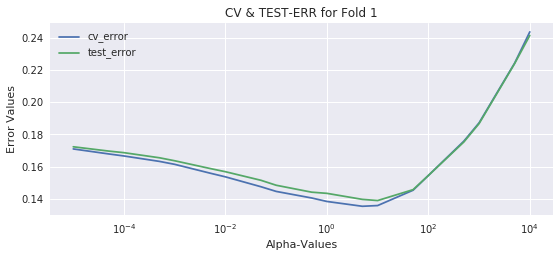

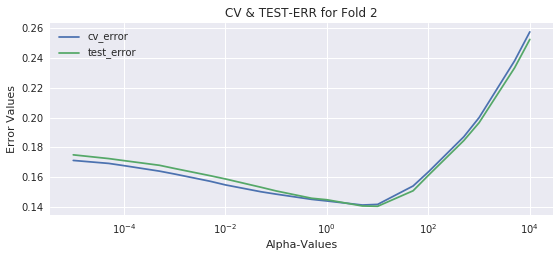

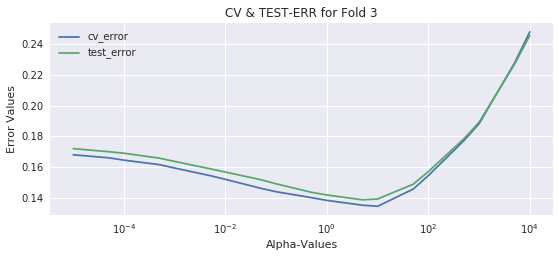

In [23]:
# plotting cv and test error for 3-Fold cross validation
error_comparision(cv_err_bow, test_err_bow)

#### Observation:
* From cv-train and cv-test error comparision it seems like alpha should be 10 as elbow shape is at 10 alpha.


Test accuracy for alpha = '10' is '86.20206618805814'


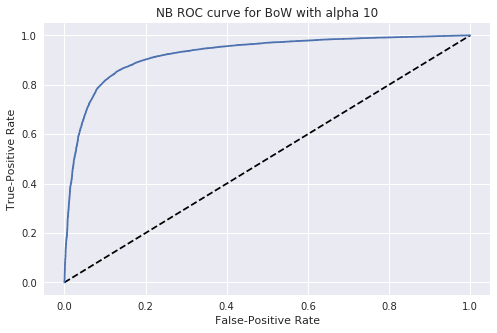

Area under the ROC curve is  0.9245282698111217

Confusion Matrix :
 [[15038  2205]
 [ 2523 14500]]

Normalized Confusion Matrix :
 [[0.87212202 0.12787798]
 [0.14821124 0.85178876]]

Precision  : 85.63%, 86.80%
Recall     : 87.21%, 85.18%
F1-score   : [0.86415355 0.85981973]


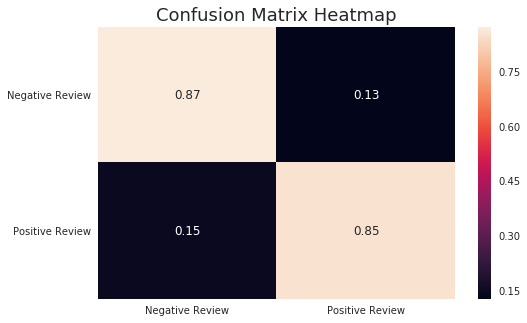

In [24]:
# model performance on test data
final_test_acc(10, 'BoW')

#### Observation:
* Test accuracy for alpha=10 is 86% if we use BoW representaion for our text-data, which is pretty good.
* True positive and true negative rates are also high, which is 85% & 87%. 

In [25]:
# printing top 10 words(features) for each class
top_features(count_vect,10,10)

Top 10 "NEGATIVE" Features are:

['liteweight' 'marudaizu' 'maruchaun' 'martyrdom' 'martyr' 'martinez'
 'martinelli' 'martial' 'martec' 'marshallow']

Top 10 "POSITIVE" Features are:

['aa' 'maravilloso' 'maraud' 'mararoni' 'mararita' 'maranta' 'maranad'
 'maran' 'marakesh' 'maragoya']


### 6.1 Bag of Words(Bi-Gram)

In [26]:
# applying BoW(Bi-Gram)
count_vect = CountVectorizer(ngram_range=(1,2))
final_bigram_counts = count_vect.fit_transform(sorted_data['CleanedText'].values)

In [27]:
final_bigram_counts.shape

(114220, 1428081)

In [28]:
# calculating cv error and test error
cv_err_bigram, test_err_bigram = cross_val(final_bigram_counts, score)

In [29]:
cv_err_bigram = np.reshape(cv_err_bigram,(3, 19))
test_err_bigram = np.reshape(test_err_bigram,(3, 19))

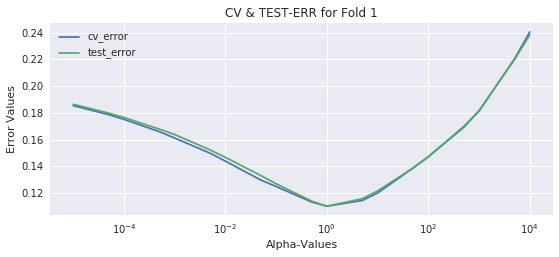

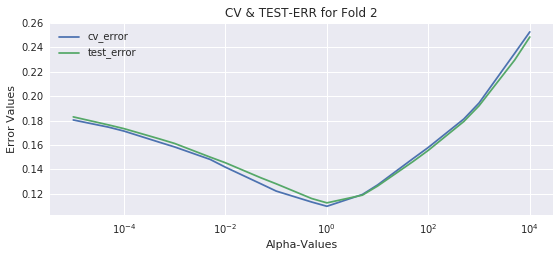

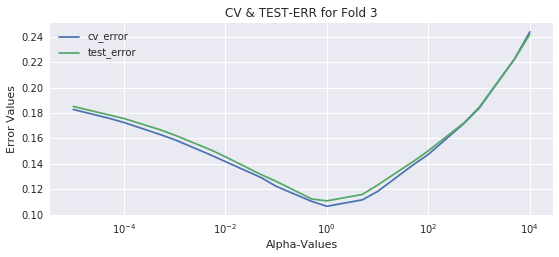

In [30]:
# plotting cv and test error for 3-Fold cross validation
error_comparision(cv_err_bigram, test_err_bigram)

#### Observation:
* For BoW(Bi-Gram), we are getting the alpha=1 from 3-Fold cross-validation.


Test accuracy for alpha = '1' is '89.17002276308878'


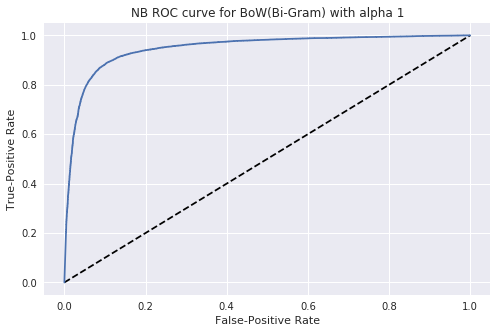

Area under the ROC curve is  0.9477422682744823

Confusion Matrix :
 [[15363  1880]
 [ 1831 15192]]

Normalized Confusion Matrix :
 [[0.89097025 0.10902975]
 [0.10756036 0.89243964]]

Precision  : 89.35%, 88.99%
Recall     : 89.10%, 89.24%
F1-score   : [0.892238   0.89115706]


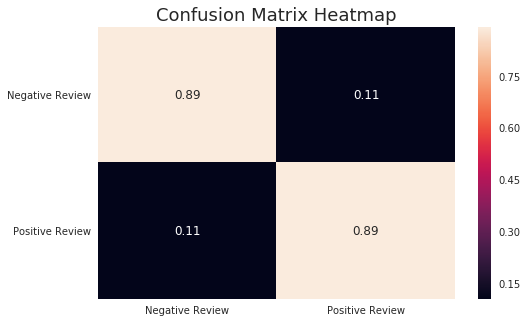

In [31]:
# model performance on test data
final_test_acc(1, 'BoW(Bi-Gram)')

#### Observation:
* The test accuracy for BoW(Bi-Gram) is little better than that of BoW(Uni-Gram). As the accuracy is 89.17%.
* True positive and true negative rates are also very high(i.e 89% for both).

In [32]:
# printing top 10 words(features) for each class
top_features(count_vect,10,1)

Top 10 "NEGATIVE" Features are:

['listen tri' 'nasti smooth' 'nasti snack' 'nasti son' 'nasti sound'
 'nasti soup' 'nasti soy' 'nasti spinach' 'nasti splenda' 'nasti spoil']

Top 10 "POSITIVE" Features are:

['aa' 'moistur massag' 'moistur matur' 'moistur maximum' 'moistur meat'
 'moistur medic' 'moistur mess' 'moistur meter' 'moistur mind'
 'moistur mix']


## 7. TF-IDF

In [33]:
# applying tf-idf vectorization 
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(sorted_data['CleanedText'].values)

In [34]:
final_tf_idf.shape

(114220, 1428081)

In [35]:
# calculating cv and test error
cv_err_tfidf, test_err_tfidf = cross_val(final_tf_idf, score)

In [36]:
cv_err_tfidf = np.reshape(cv_err_tfidf,(3, 19))
test_err_tfidf = np.reshape(test_err_tfidf,(3, 19))

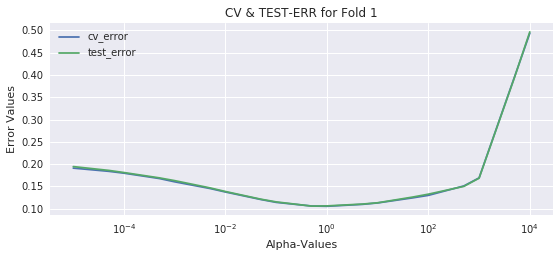

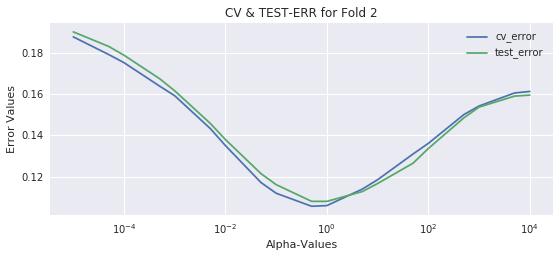

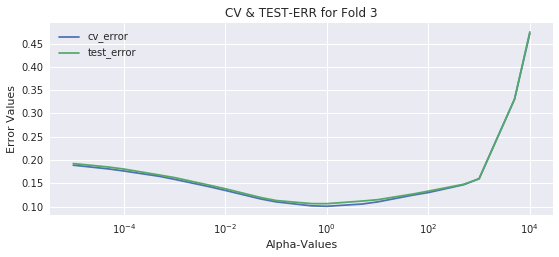

In [37]:
# plotting cv and test error for 3-Fold cross validation
error_comparision(cv_err_tfidf, test_err_tfidf)

#### Observation:
* We are getting a minimum error at alpha=0.8. So best-fit alpha should be 0.8. 


Test accuracy for alpha = '0.8' is '89.63403957275433'


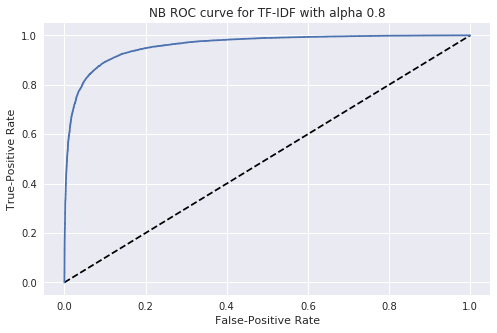

Area under the ROC curve is  0.9595734338280549

Confusion Matrix :
 [[15580  1663]
 [ 1889 15134]]

Normalized Confusion Matrix :
 [[0.90355507 0.09644493]
 [0.11096751 0.88903249]]

Precision  : 89.19%, 90.10%
Recall     : 90.36%, 88.90%
F1-score   : [0.89767227 0.89497339]


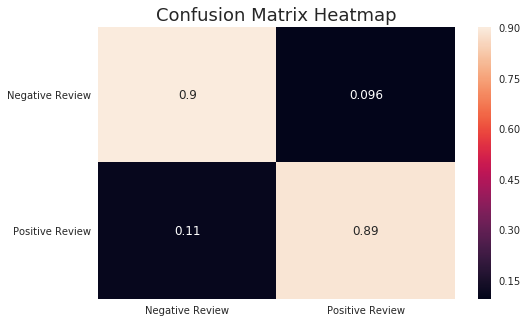

In [38]:
# model performance on test data
final_test_acc(0.8, 'TF-IDF')

#### Observation:
* For TF-IDF we are getting nearly similar result to the BoW(Bi-Gram), but a little better.
* The overall accuracy of this model for TF-IDF is 89.6%.
* True positive and true negative rates are also high, which is 89% and 90%.

In [39]:
# printing top 10 words(features) for each class
top_features(tf_idf_vect,10,0.8)

Top 10 "NEGATIVE" Features are:

['listen tri' 'nasti smooth' 'nasti snack' 'nasti son' 'nasti sound'
 'nasti soup' 'nasti soy' 'nasti spinach' 'nasti splenda' 'nasti spoil']

Top 10 "POSITIVE" Features are:

['aa' 'moistur massag' 'moistur matur' 'moistur maximum' 'moistur meat'
 'moistur medic' 'moistur mess' 'moistur meter' 'moistur mind'
 'moistur mix']


## 8. Conclusion:

* Naive Bayes algorithm's performance for text classification is outstanding, as Naive Bayes is considered as a base-model for text-classification task.
* For our data-set Naive Bayes performs best(i.e ~ 89.6%) for TF-IDF representation of text data.